In [3]:
# from analyse import prepare_data
import matplotlib.pyplot as plt
import numpy as np
from analyse import extract_data
from statistics import stdev, mean

In [4]:
default_fig_size = [14, 10]
extended_fig_size = [30, 100]
plt.rcParams['figure.figsize'] = default_fig_size
plt.rcParams.update({'font.size': 20})

In [5]:
energy_opt, stats_opt, info_opt = extract_data('/home/serchio/Documents/COAT/lora_wakeup/data/sx1262_optimal', new_format=True)
energy_nbs, stats_nbs, info_nbs = extract_data('/home/serchio/Documents/COAT/lora_wakeup/data/sx1262_nbs', new_format=True)
energy_perf, stats_perf, info_perf = extract_data('/home/serchio/Documents/COAT/lora_wakeup/data/sx1262_performance', new_format=True)
energy_join, stats_join, info_join = extract_data('/home/serchio/Documents/COAT/lora_wakeup/data/sx1262_join', new_format=True)
energy_dcw, stats_dcw, info_dcw = extract_data('/home/serchio/Documents/COAT/lora_wakeup/data/sx1262_dcw2', new_format=True)
energy_dcw2, stats_dcw2, info_dcw2 = extract_data('/home/serchio/Documents/COAT/lora_wakeup/data/sx1262_dcw3', new_format=True)

In [6]:
def get_keys(data, requested_kbytes, nr_of_dev=None, dw=None, dcw=None, lorawan=True):
    to_find = f'_{requested_kbytes}'
    if nr_of_dev is not None:
        to_find = f'_{requested_kbytes}_{nr_of_dev}'
    requested_keys = []
    for key in data.keys():
        if key.find(to_find) >= 0:
            requested_keys.append(key)
    
    filtered_keys = []
    final_keys = []
    for key in requested_keys:
        if key.find('colora') >= 0:
            filtered_keys.append(key)
        if lorawan and key.find('lorawan') >= 0:
            final_keys.append(key)
    
    if dw is not None and dcw is not None:
        for key in filtered_keys:
            if lorawan and key.find('lorawan') >= 0:
                final_keys.append(key)
                continue
            if key.find(f'{dw}_{dcw}') >= 0:
                final_keys.append(key)
    else:
        final_keys += filtered_keys
        
    return final_keys

def get_avg_joules(data, keys):
    gw = []
    eds = []
    eds_stdev = []
    for key in keys:
#         tmp_key_data = data[key]
        gw.append(data[key][0][0])
        key_eds = [data[key][x][0] for x in data[key] if x >= 1]
        if len(key_eds) > 1:
            eds.append(mean(key_eds))
            eds_stdev.append(stdev(key_eds))
        else:
            eds.append(key_eds[0])
            eds_stdev.append(0.0)
        
    return gw, eds, eds_stdev

def prepare_labels(keys, info):
    labels = []
    for key in keys:
        if key.find('lorawan') >= 0:
            labels.append(f'LoRaWAN: 1 x ED\nTd = {info[key]["delay"]}s')
            continue
            
        nr_dev = key.split('_')[2]
#         labels.append(f'CoLoRa: {nr_dev} x EDs\nTd = {info[key]["delay"]}s, Tdw = {info[key]["dw"]}s, Tdcw = {info[key]["dcw"]}s')
        labels.append(f'CoLoRa: {nr_dev} x ED\nTd = {info[key]["delay"]}s')
        
    return labels

In [7]:
# keys_512 = ['lorawan_512_1', 'colora_512_1_20_20', 'colora_512_5_20_20', 'colora_512_10_20_20', 'colora_512_15_20_20', 'colora_512_20_20_20']
keys_128 = ['lorawan_128_1', 'colora_128_1_6_11', 'colora_128_5_13_24', 'colora_128_10_22_41', 'colora_128_15_31_57', 'colora_128_20_39_74']
keys_256 = ['lorawan_256_1', 'colora_256_1_6_11', 'colora_256_5_13_24', 'colora_256_10_22_41', 'colora_256_15_31_57', 'colora_256_20_39_74']
keys_512 = ['lorawan_512_1', 'colora_512_1_6_11',  'colora_512_5_13_24', 'colora_512_10_22_41', 'colora_512_15_31_57', 'colora_512_20_39_74']
keys_1024 = ['lorawan_1024_1', 'colora_1024_1_6_11',  'colora_1024_5_13_24', 'colora_1024_10_22_41', 'colora_1024_15_31_57', 'colora_1024_20_39_74']
legend = ['LoRaWAN: 20 ED', 'CoLoRa: 1 CN', 'CoLoRa: 5 CN', 'CoLoRa: 10 CN', 'CoLoRa: 15 CN', 'CoLoRa: 20 CN']
labels = [128, 256, 512, 1024]

keys = []
for i in range(0, len(keys_128)):
    k = []
    k.append(keys_128[i])
    k.append(keys_256[i])
    k.append(keys_512[i])
    k.append(keys_1024[i])
    keys.append(k)

gw = []
dev = []
dev_std = []
delay = []
for key in keys:
    t_gw, t_dev, t_dev_std = get_avg_joules(energy_opt, key)
    gw.append(t_gw)
    dev.append(t_dev)
    dev_std.append(t_dev_std)
    t_delay = [info_opt[x]['delay'] for x in key]
    delay.append(t_delay)

# print(stats_opt['colora_1024_1_6_11'])
# gw, dev, dev_std = get_avg_joules(energy_opt, keys_512)
# labels_512 = prepare_labels(keys_512, info_opt)
# compare_to_lorawan(labels_512, gw, dev, dev_std)

In [8]:
def plot_overview(labels, legend, data, x_label, y_label=None, sub=False, std=None):
    import math
    from matplotlib.lines import Line2D
    f_size = 20

    if sub:
        l_legend = legend[0]
        l_data = data[0]
        legend = legend[1:]
        data = data[1:]
    
    x = np.arange(len(labels))  # the label locations
    x = labels  # the label locations
    
    styles = ['v--', 'o--', '^--', 's--', 'D--', 'p--']
    fig, ax = plt.subplots()
    for i in range(0, len(data)):
        ax.plot(x, data[i], styles.pop(), label=legend[i], markersize=8)
        if std is not None:
#             plt.errorbar(x, data[i], std[i], linestyle='None', marker='^')
            plt.errorbar(x, data[i], yerr=std[i], fmt='none', ecolor='black', elinewidth=1, capsize=2)
    
    if sub:
        ins = ax.inset_axes([0.37,0.73,0.3,0.23])
        ins.set_xticks([x for x in range(0, 1024 + 128, 1024)])
        ins.set_xticklabels([f'{x}KB' for x in range(0, 1024 + 128, 1024)])
        ins.plot([0, 1024], [l_data, l_data], 'k-')
#         ins.set_yticks()
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    if y_label is not None:
        ax.set_ylabel(y_label)
    else:
        ax.set_ylabel('Estimated energy consumption [Joules]')

    ax.set_xlabel(x_label)
    # ax.set_title('Estimated energy usage for various scenarios for a period of 365 days')
#     ax.set_title('Simulated battery capacity required for the device to work in various scenarios for a period of 365 days')
    ax.set_xticks([x for x in range(128, 1024 + 128, 128)])
    lim = ax.get_ylim()
    if lim[1] > 15000:
        max_y = math.floor(lim[1] / 5000) * 5000
        ax.set_yticks([x for x in range (0, max_y + 5000, 5000)])
        for label in ax.yaxis.get_ticklabels()[::2]:
            label.set_visible(False)
    ax.set_xticklabels([f'{x}KB' for x in range(128, 1024 + 128, 128)])
#     ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    if sub:
        line = Line2D([0], [0], color='k', lw=2, linestyle='-', label=l_legend)
        # manually define a new patch 
#         patch = mpatches.Patch(color='grey', label='Manual Label')
        # handles is a list, so append manual patch
        handles.append(line) 
#     ax.set_yscale('log')
    ax.legend(handles=handles, fontsize=f_size)
#     ax.legend(fontsize=f_size)


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(int(round(height, 0))),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=f_size - 2)


#     autolabel(rects1)
#     autolabel(rects2)

    fig.tight_layout()

    plt.show()
    
def plot_overview_bars_eds(labels, legend, data, x_label, y_label=None, sub=False, std=None):
    f_size = 20
    
    x = np.arange(len(labels))  # the label locations
    width = 0.9  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/6*2.5, data[0], width/6, label=legend[0])
    rects2 = ax.bar(x - width/6*1.5, data[1], width/6, label=legend[1])
    rects3 = ax.bar(x - width/6/2, data[2], width/6, label=legend[2])
    rects4 = ax.bar(x + width/6/2, data[3], width/6, label=legend[3])
    rects5 = ax.bar(x + width/6*1.5, data[4], width/6, label=legend[4])
    rects6 = ax.bar(x + width/6*2.5, data[5], width/6, label=legend[5])

    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    ax.legend(fontsize=f_size, loc='upper left')
    ax.grid(True)

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if int(round(height, 0)) == 0.0:
                continue
            ax.annotate('{}'.format(int(round(height, 0))),
                        xy=(rect.get_x() + rect.get_width() / 6 * 3, height),
#                         xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=f_size - 2, weight='bold')


    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)
    autolabel(rects6)
    colors = []
    for i in range(1, 7):
        rects = vars()[f'rects{i}']
        colors.append(rects[0].get_facecolor())

    plt.show()
    return colors
    
def plot_overview_bars_gws(labels, legend, data, x_label, y_label, colors):
    from matplotlib.patches import Patch
    f_size = 20
    
    x = np.arange(len(labels))  # the label locations
    width = 0.9  # the width of the bars
    fig, ax = plt.subplots()
    handles = []
    for l in range(0, len(legend)):
        patch = Patch(color=colors[l], label=legend[l])
        handles.append(patch)
    ax.legend(handles=handles, fontsize=f_size)
#     rects1 = ax.bar(x - width/6*2.5, data[0], width/6, label=legend[0])
    rects2 = ax.bar(x - width/5*2, data[1], width/5, label=legend[1], color=colors[1])
    rects3 = ax.bar(x - width/5, data[2], width/5, label=legend[2], color=colors[2])
    rects4 = ax.bar(x, data[3], width/5, label=legend[3], color=colors[3])
    rects5 = ax.bar(x + width/5, data[4], width/5, label=legend[4], color=colors[4])
    rects6 = ax.bar(x + width/5*2, data[5], width/5, label=legend[5], color=colors[5])
    
    ins = ax.inset_axes([0.4,0.67,0.05,0.23])
    ins.set_xticks([0])
    ins.bar([0], data[0], width/5, color=colors[0])
    ins_y_labels = []
    ins_y = ins.get_yticks()
    for y in ins_y:
        if y == 0:
            ins_y_labels.append(f'0')
            continue
        ins_y_labels.append(f'{int(y / 1000000)}M')
    ins.set_yticks(ins_y)
    ins.set_yticklabels(ins_y_labels)
    ins.grid(True)
        
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    ax.grid(True)


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if int(round(height, 0)) == 0.0:
                continue
            ax.annotate('{}'.format(int(round(height, 0))),
                        xy=(rect.get_x() + rect.get_width() / 6 * 3, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=f_size - 2, weight='bold')


    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)
    autolabel(rects6)
    
    plt.show()

# Energy EDs

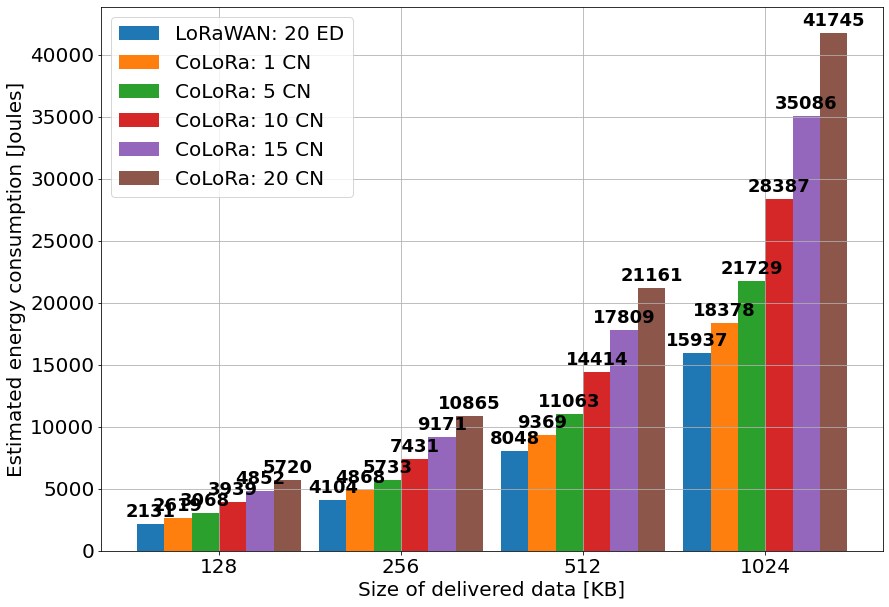

In [9]:
# plot_overview(labels, legend, dev, 'Size of delivered data [KB]')
colors = plot_overview_bars_eds(labels, legend, dev, 'Size of delivered data [KB]', 'Estimated energy consumption [Joules]')

# Energy GWs

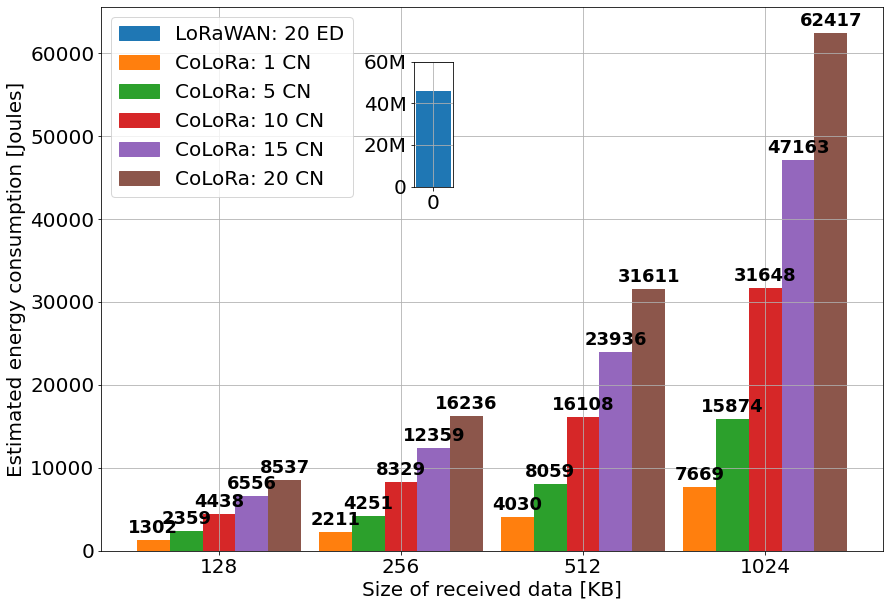

In [10]:
# plot_overview(labels, legend, gw, 'Size of requested data [KB]', sub=True)
plot_overview_bars_gws(labels, legend, gw, 'Size of received data [KB]', 'Estimated energy consumption [Joules]', colors)

# Delay EDs

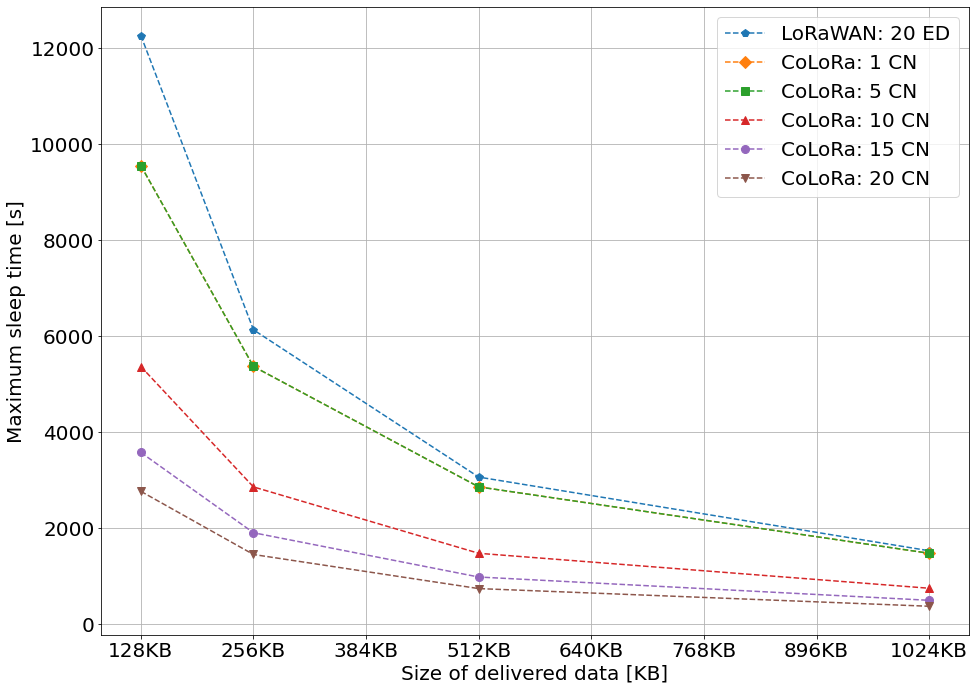

In [11]:
plot_overview(labels, legend, delay, 'Size of delivered data [KB]', 'Maximum sleep time [s]')

In [35]:
def compare_to_lorawan(labels, gw, dev, log_scale=True, rotate_labels=False, rotate_values=False, max_y=None, lorawan=False, show_diff=False):
    f_size = 20

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars
    
    fig, ax = plt.subplots()
    lgw = 0
    led = 0
    if not lorawan:
        rects1 = ax.bar(x - width/2, gw, width, label='PN')
        rects2 = ax.bar(x + width/2, dev, width, label='CN')
    else:
        lgw = gw[0]
        led = dev[0]
        rects1 = ax.bar(x - width/2, gw, width, label='GW - PN')
        rects2 = ax.bar(x + width/2, dev, width, label='ED - CN')
#     plt.errorbar(x + width/2, dev, yerr=dev_std, fmt='none', ecolor='black', elinewidth=1, capsize=10)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Joules')
    # ax.set_title('Estimated energy usage for various scenarios for a period of 365 days')
#     ax.set_title('Simulated battery capacity required for the device to work in various scenarios for a period of 365 days')
    ax.set_xticks(x)
    if not rotate_labels:
        ax.set_xticklabels(labels)
    else:
        ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    if log_scale:
        ax.set_yscale('log')
    ax.legend(fontsize=f_size)
    ax.grid(True)
    if max_y is not None:
        lim = ax.get_ylim()
        ax.set_ylim(lim[0], max_y)

    def autolabel(rects, ref=0):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if not rotate_values:
                ax.annotate('{}'.format(int(round(height, 0))),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=f_size - 2)
                if show_diff and ref > 0 and ref != height:
                    diff = (ref / height) if ref > height else (height / ref)
                    per = (height * 100 / ref)
                    ax.annotate('{}x'.format(round(diff, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 22),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=f_size - 6, color="red")
                    ax.annotate('{}%'.format(round(per, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 41),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=f_size - 6, color="blue")
            else:
                ax.annotate('{}'.format(int(round(height, 0))),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(2, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=f_size - 2, rotation=90)


    autolabel(rects1, lgw)
    autolabel(rects2, led)

    fig.tight_layout()

    plt.show()
    
def bytes_bar(labels, data, y_label=None, x_label=None, rotate_labels=False, rotate_values=False, max_y=None):
    f_size = 20

    x = np.arange(len(labels))  # the label locations
    width = 0.45  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, data, width)
#     rects2 = ax.bar(x + width/2, dev, width, label='END-DEVICE')
#     plt.errorbar(x + width/2, dev, yerr=dev_std, fmt='none', ecolor='black', elinewidth=1, capsize=10)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Bytes sent [KB]')
    if y_label is not None:
        ax.set_ylabel(y_label)
    if x_label is not None:
        ax.set_xlabel(x_label)
    # ax.set_title('Estimated energy usage for various scenarios for a period of 365 days')
#     ax.set_title('Simulated battery capacity required for the device to work in various scenarios for a period of 365 days')
    ax.set_xticks(x)
    if not rotate_labels:
        ax.set_xticklabels(labels)
    else:
        ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    if max_y is not None:
        lim = ax.get_ylim()
        ax.set_ylim(lim[0], max_y)
#     ax.set_yscale('log')
#     ax.legend(fontsize=f_size)


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if not rotate_values:
                ax.annotate('{}'.format(int(round(height, 0))),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=f_size - 2)
            else:
                ax.annotate('{}'.format(int(round(height, 0))),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(2, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=f_size - 2, rotation=90)


    autolabel(rects1)
#     autolabel(rects2)

    fig.tight_layout()

    plt.show()

In [22]:
# keys_perf = ['lorawan_max_1', 'colora_max_1_5_8', 'colora_max_5_10_17', 'colora_max_10_17_29', 'colora_max_15_24_41', 'colora_max_20_31_52']
keys_perf = ['lorawan_max_1', 'colora_max_1_6_11', 'colora_max_5_13_24', 'colora_max_10_22_41', 'colora_max_15_31_57', 'colora_max_20_39_74']


# print(stats_perf['colora_max_5_10_17'])
# print(stats_perf['lorawan_max_1'])
bytes_perf = [round(stats_perf['lorawan_max_1'][1][1] / 1024, 0)]
packets_perf = [stats_perf['lorawan_max_1'][1][0]]
for key in keys_perf[1:]:
    bytes_perf.append(round(stats_perf[key][1][2] / 1024, 2))
    packets_perf.append(stats_perf[key][1][0])
    
# print(bytes_perf)
# print(packets_perf)
gw, dev, _ = get_avg_joules(energy_perf, keys_perf)

# Performance

## Max bytes

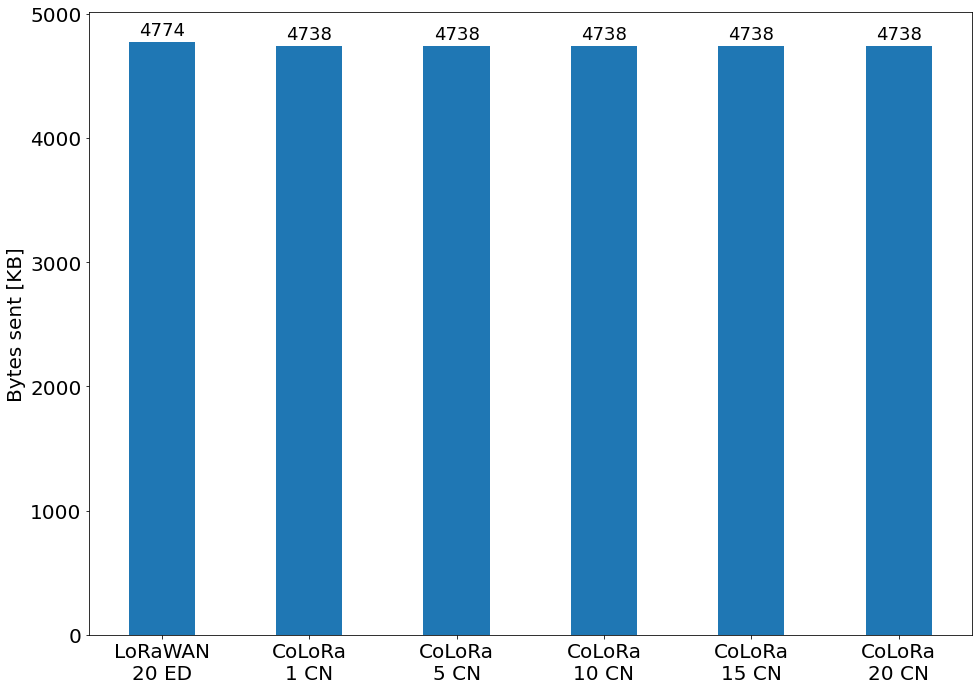

In [14]:
legend = ['LoRaWAN\n20 ED', 'CoLoRa\n1 CN', 'CoLoRa\n5 CN', 'CoLoRa\n10 CN', 'CoLoRa\n15 CN', 'CoLoRa\n20 CN']
bytes_bar(legend, bytes_perf)

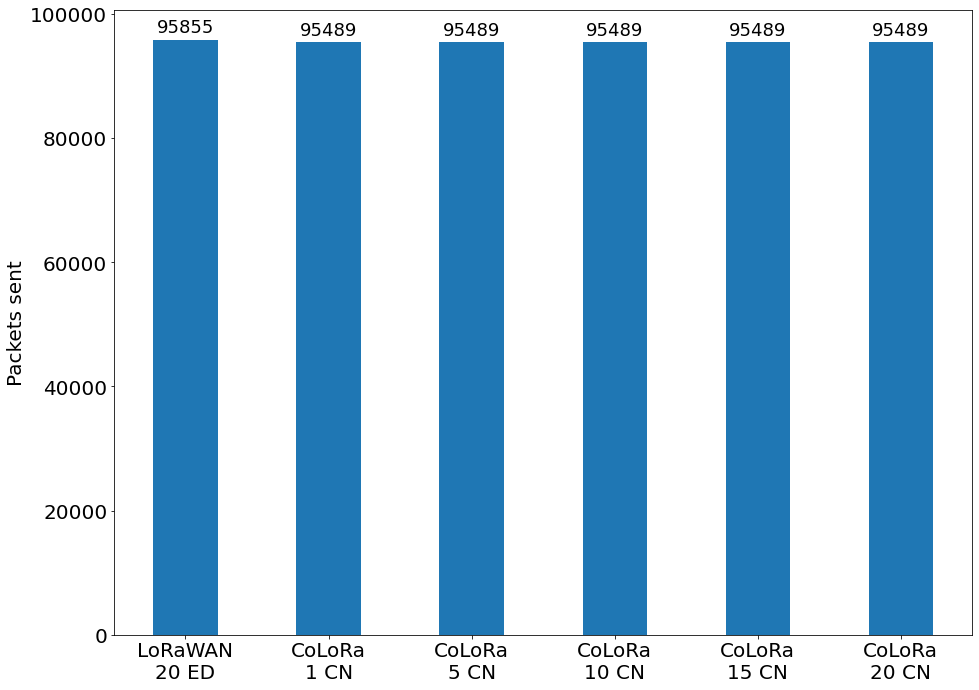

In [15]:
bytes_bar(legend, packets_perf, 'Packets sent')

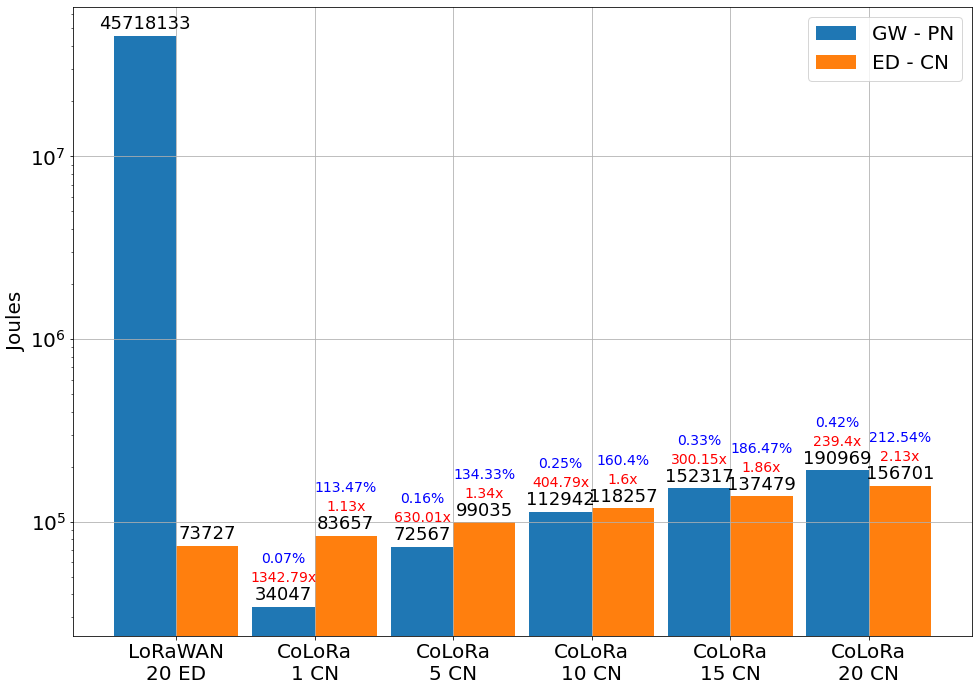

In [36]:
compare_to_lorawan(legend, gw, dev, lorawan=True, show_diff=True)

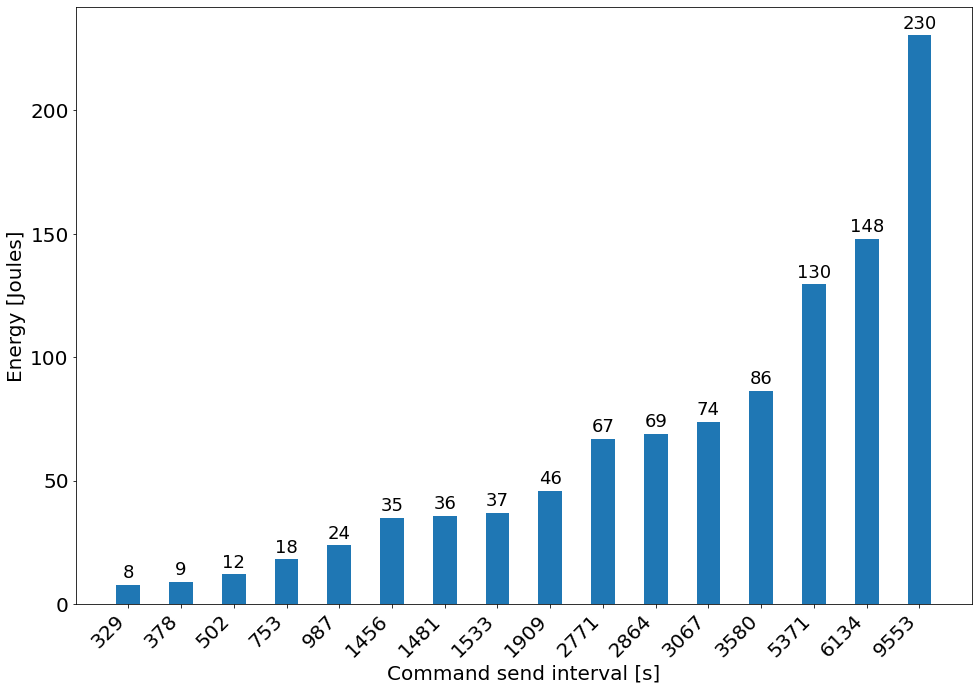

In [15]:
keys_join = []
delay_join = []
# for key in info_opt:
# #     print(f'{key}: {info_opt[key]["delay"]}')
#     keys_join.append(key)
#     delay_join.append(info_opt[key]["delay"])
# #     delay_join.append(key)
    
# join_sorted = sorted(zip(delay_join, keys_join), key=lambda x: x[0])
# for key, value in join_sorted:
#     print(key, value)
for key in info_join:
    keys_join.append(key)
    delay_join.append(info_join[key]['delay'])
    
join_sorted = sorted(zip(delay_join, keys_join), key=lambda x: x[0])
legend = []
keys_join = []
data = []
for key, value in join_sorted:
    legend.append(key)
    keys_join.append(value)
    data.append(energy_join[value][1][0])
    
bytes_bar(legend, data, 'Energy [Joules]', 'Command send interval [s]', True)

In [16]:
def get_min_max_joules(data, keys):
    gw = []
    eds = []
    eds_stdev = []
    for key in keys:
#         tmp_key_data = data[key]
        gw.append(data[key][0][0])
        key_eds = [data[key][x][0] for x in data[key] if x >= 1]
        if len(key_eds) > 1:
            eds.append(min(key_eds))
            eds.append(max(key_eds))
        
    return gw, eds

[61295.58, 62416.76, 61295.58]
[25833.1, 41744.9945, 57652.36]


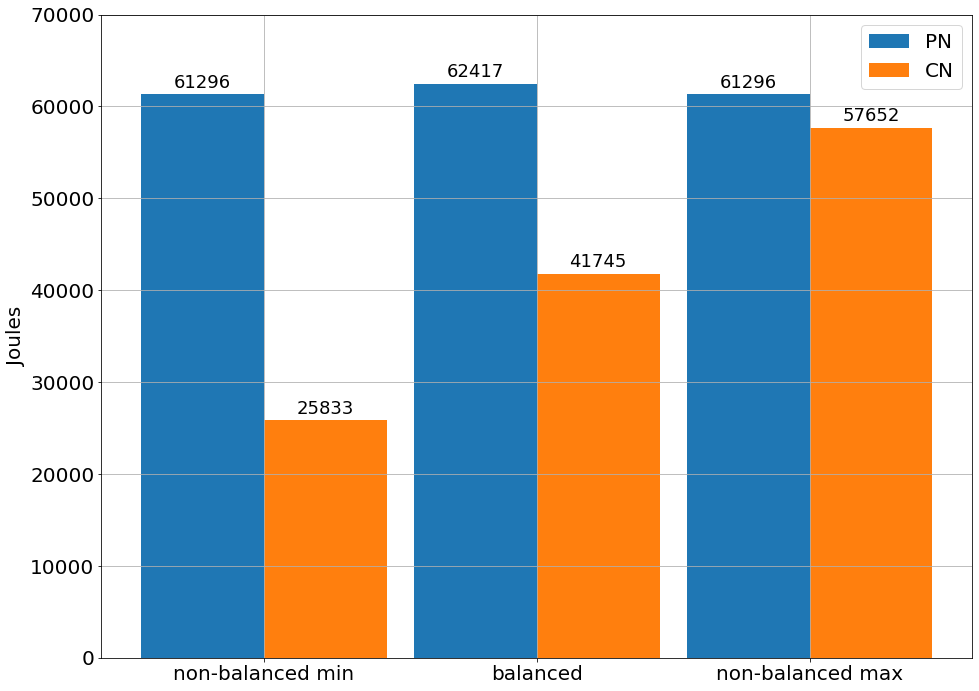

In [17]:
gw_opt, dev_opt, _ = get_avg_joules(energy_opt, ['colora_1024_20_39_74'])
gw_nbs, dev_nbs = get_min_max_joules(energy_nbs, ['colora_1024_20_39_74'])

gw = [gw_nbs[0], gw_opt[0], gw_nbs[0]]
dev = [dev_nbs[0], dev_opt[0], dev_nbs[1]]
print(gw)
print(dev)
legend = ['non-balanced min', 'balanced', 'non-balanced max']
compare_to_lorawan(legend, gw, dev, False, max_y=70000)

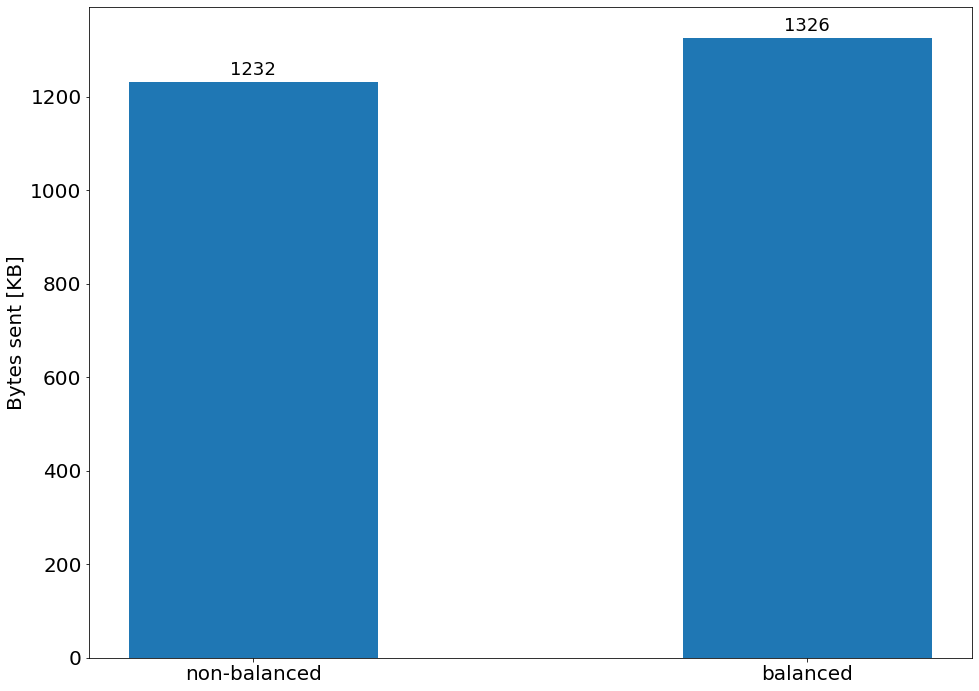

In [18]:
# print(stats_opt['colora_1024_20_39_74'][0][1])
bytes_nbs_bs = []
bytes_nbs_bs.append(round(stats_nbs['colora_1024_20_39_74'][0][1] / 1024, 2))
bytes_nbs_bs.append(round(stats_opt['colora_1024_20_39_74'][0][1] / 1024, 2))
bytes_bar(['non-balanced', 'balanced'], bytes_nbs_bs)

# DCW effect on energy usage

In [19]:
# keys_dcw = ['colora_512_20_39_5', 'colora_512_20_39_10', 'colora_512_20_39_20', 'colora_512_20_39_40', 'colora_512_20_39_80']
keys_dcw = ['colora_512_20_39_20', 'colora_512_20_39_40', 'colora_512_20_39_80']
# keys_dcw2 = ['colora_512_20_39_10', 'colora_512_20_39_20', 'colora_512_20_39_40', 'colora_512_20_39_80']
keys_dcw_128 = ['colora_128_20_39_5', 'colora_128_20_39_10', 'colora_128_20_39_15', 'colora_128_20_39_20', 'colora_128_20_39_25', 'colora_128_20_39_30', 'colora_128_20_39_35', 'colora_128_20_39_40', 'colora_128_20_39_45', 'colora_128_20_39_50', 'colora_128_20_39_55', 'colora_128_20_39_60', 'colora_128_20_39_65', 'colora_128_20_39_70', 'colora_128_20_39_75']
keys_dcw_128_d = ['colora_128_20_39_4', 'colora_128_20_39_7', 'colora_128_20_39_11', 'colora_128_20_39_14', 'colora_128_20_39_17', 'colora_128_20_39_21', 'colora_128_20_39_24', 'colora_128_20_39_27', 'colora_128_20_39_31', 'colora_128_20_39_34', 'colora_128_20_39_37', 'colora_128_20_39_44', 'colora_128_20_39_47', 'colora_128_20_39_51', 'colora_128_20_39_54', 'colora_128_20_39_57', 'colora_128_20_39_61', 'colora_128_20_39_64', 'colora_128_20_39_67', 'colora_128_20_39_71']
gw_dcw, dev_dcw, _ = get_avg_joules(energy_dcw, keys_dcw)
gw_dcw_128, dev_dcw_128, _ = get_avg_joules(energy_dcw, keys_dcw_128)
gw_dcw_128_d, dev_dcw_128_d, _ = get_avg_joules(energy_dcw2, keys_dcw_128_d)
# gw_dcw2, dev_dcw2, _ = get_avg_joules(energy_dcw2, keys_dcw2)
# legend = ['DCW: 5', 'DCW: 10', 'DCW: 20', 'DCW: 40', 'DCW: 80']
legend = ['DCW: 20s', 'DCW: 40s', 'DCW: 80s']
legend_128 = ['DCW: 5s', 'DCW: 10s', 'DCW: 15s', 'DCW: 20s', 'DCW: 25s', 'DCW: 30s', 'DCW: 35s', 'DCW: 40s', 'DCW: 45s', 'DCW: 50s', 'DCW: 55s', 'DCW: 60s', 'DCW: 65s', 'DCW: 70s', 'DCW: 75s']
legend_128_d = ['DCW: 4s - Q: 1', 'DCW: 7s - Q: 2', 'DCW: 11s - Q: 3', 'DCW: 14s - Q: 4', 'DCW: 17s - Q: 5', 'DCW: 21s - Q: 6', 'DCW: 24s - Q: 7', 'DCW: 27s - Q: 8', 'DCW: 31s - Q: 9', 'DCW: 34s - Q: 10', 'DCW: 37s - Q: 11', 'DCW: 44s - Q: 12', 'DCW: 47s - Q: 13', 'DCW: 51s - Q: 14', 'DCW: 54s - Q: 15', 'DCW: 57s - Q: 16', 'DCW: 61s - Q: 17', 'DCW: 64s - Q: 18', 'DCW: 67s - Q: 19', 'DCW: 71s - Q: 20']
# legend2 = ['DCW: 10', 'DCW: 20', 'DCW: 40', 'DCW: 80']
delay_dcw = [info_dcw[x]['delay'] for x in keys_dcw]
delay_dcw_128 = [info_dcw[x]['delay'] for x in keys_dcw_128]
delay_dcw_128_d = [info_dcw2[x]['delay'] for x in keys_dcw_128_d]
# delay_dcw2 = [info_dcw[x]['delay'] for x in keys_dcw2]

## Energy usage

### 512KB

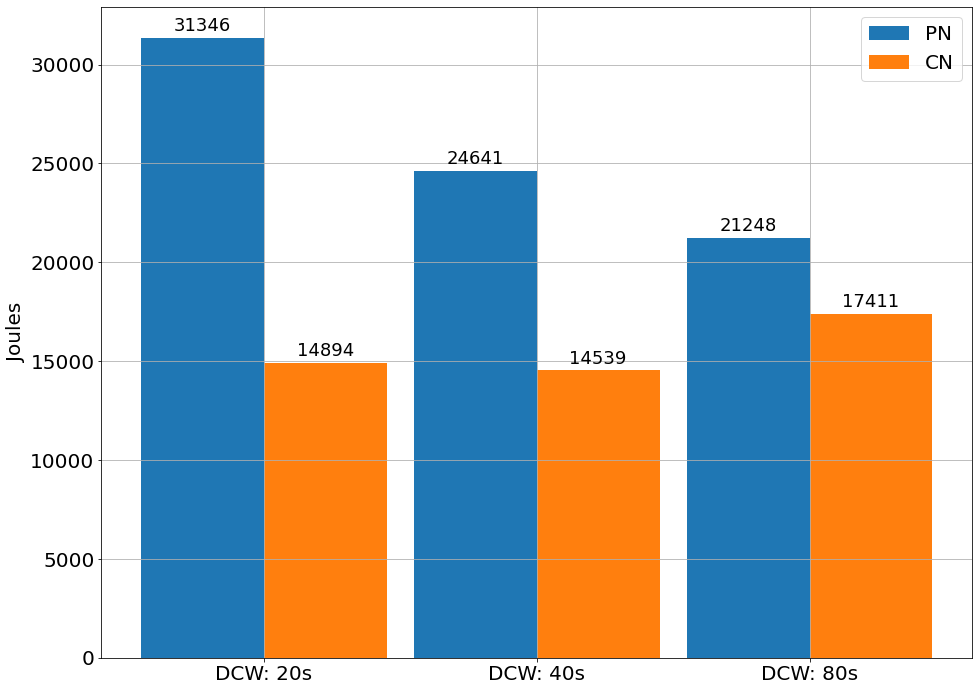

In [20]:
compare_to_lorawan(legend, gw_dcw, dev_dcw, False)

# compare_to_lorawan(legend2, gw_dcw2, dev_dcw2, False)

### 128KB - 5s steps for DCW

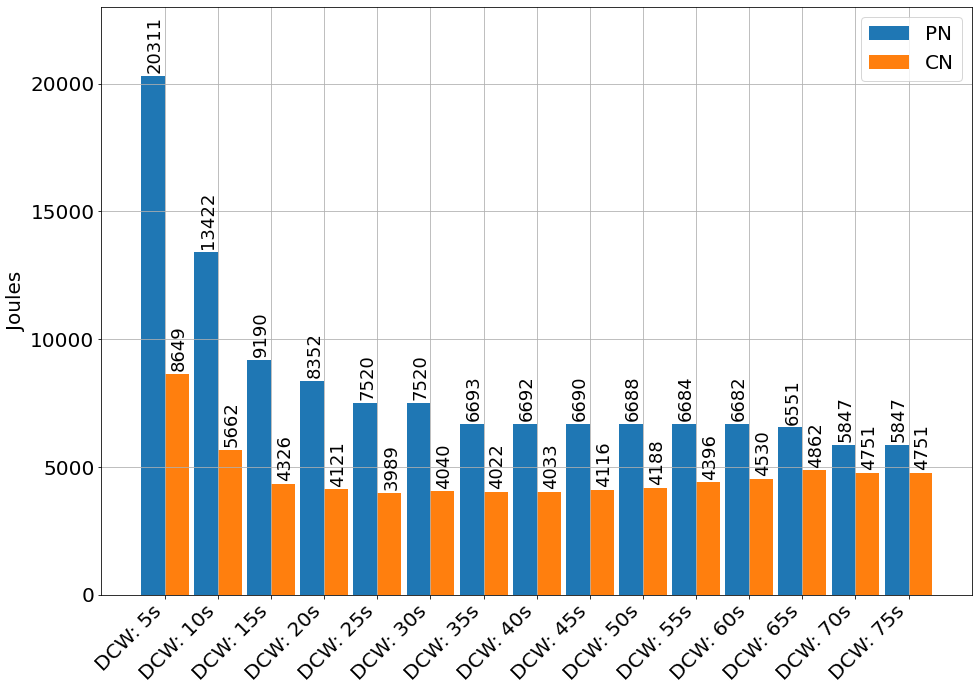

In [21]:
compare_to_lorawan(legend_128, gw_dcw_128, dev_dcw_128, False, True, True, 23000)

### 128KB - 1 more device each DCW

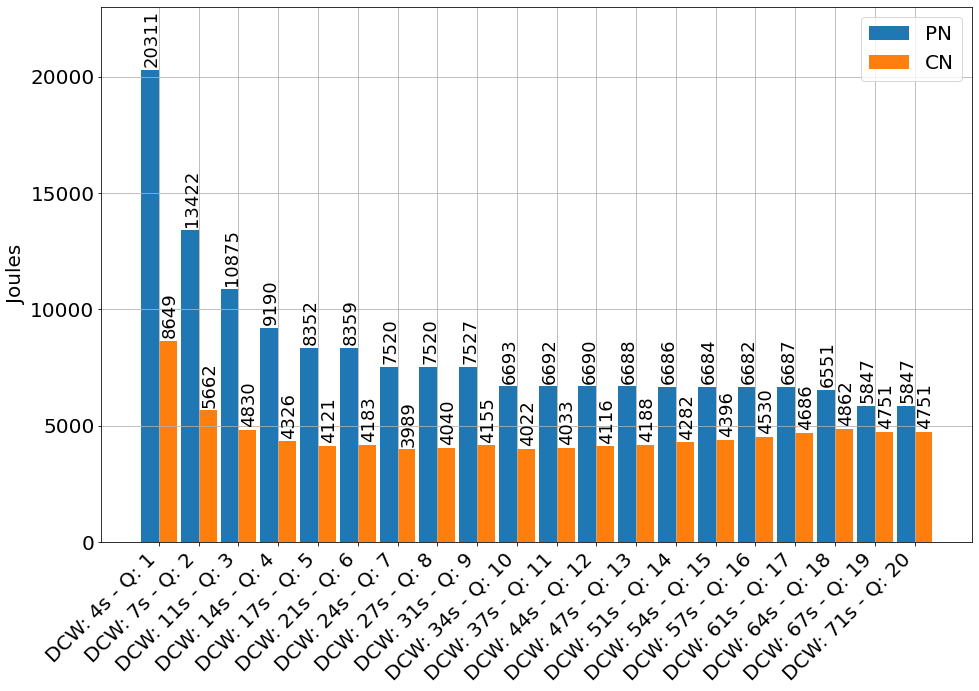

In [22]:
compare_to_lorawan(legend_128_d, gw_dcw_128_d, dev_dcw_128_d, False, True, True, 23000)

## Send interval

### 512KB

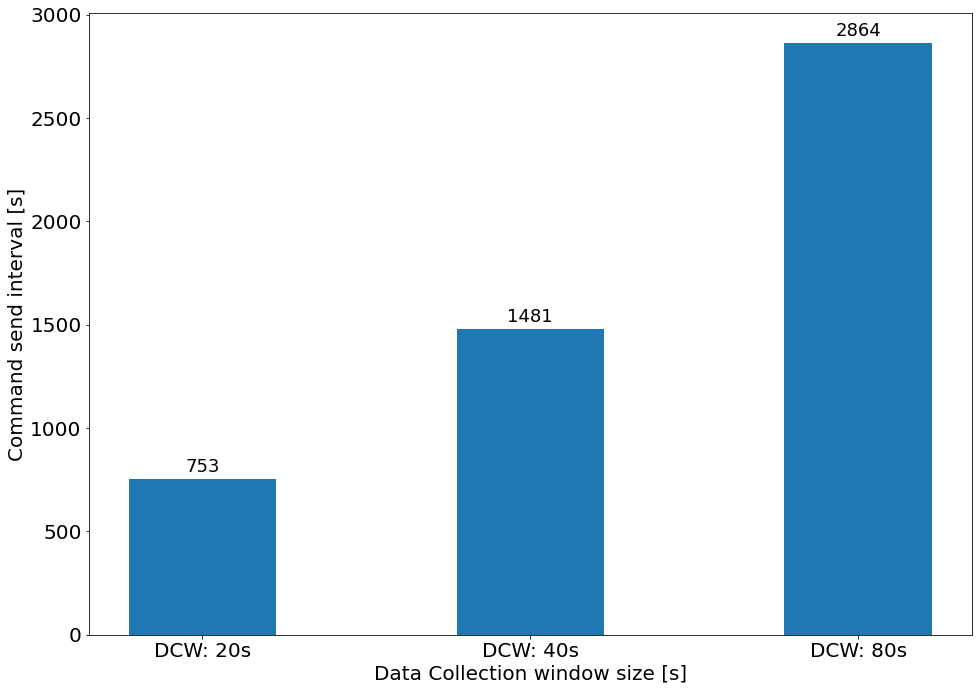

In [23]:
bytes_bar(legend, delay_dcw, 'Command send interval [s]', 'Data Collection window size [s]' , False)
# bytes_bar(legend2, delay_dcw2, 'Command send interval [s]', 'Data Collection window size [s]' , False)

### 128KB - 5s steps for DCW

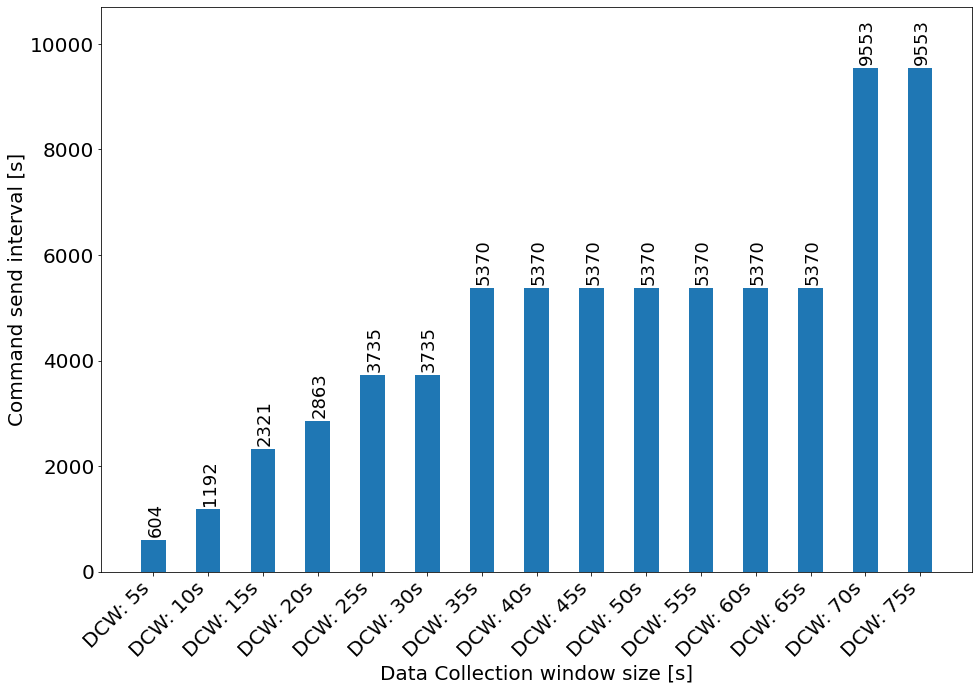

In [24]:
bytes_bar(legend_128, delay_dcw_128, 'Command send interval [s]', 'Data Collection window size [s]' , True, rotate_values=True, max_y=10700)

### 128KB - 1 more device each DCW

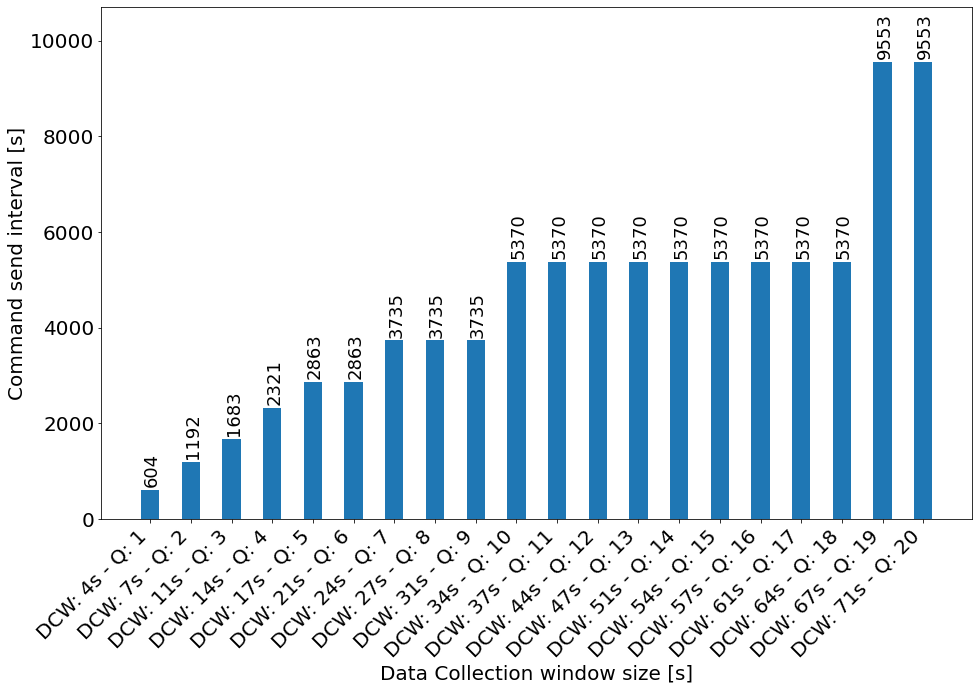

In [25]:
bytes_bar(legend_128_d, delay_dcw_128_d, 'Command send interval [s]', 'Data Collection window size [s]' , True, rotate_values=True, max_y=10700)